In [ ]:
# For data profiling and pycaret
!pip install "matplotlib>=3.2,<=3.7.3"
!pip install "ydata-profiling>4.4,<4.5" pycaret
!pip install tensorflow sdv

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras

2023-12-04 12:48:18.963196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 12:48:19.175310: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 12:48:19.175365: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 12:48:19.176480: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 12:48:19.285731: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 12:48:19.287431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Setup
conda create --name "pia-tf" python=3.10.9 ipython
conda activate pia-tf
conda install jupyter pip
pip install pandas numpy tensorflow keras-tuner
conda deactivate && python -m ipykernel install --user --name pia-tf
nano ~/.local/share/jupyter/kernels/pia-tf/kernel.json

## Ideas

If adversary does not work, predict -> predict_proba to get more information

In [2]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from pia_functions import data_train_test, get_distributed_adult_sets, generate_shadow_model_outputs, train_gradient_boosting_shadow_model

### Generate training data for shadow models

In [ ]:
n_shadow_models=200
distributions=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [23]:
X_train, X_test, y_train, y_test, sensitive, sensitive_t = data_train_test()

In [13]:
model_input

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,69,70,71,72,73,74,75,76,77,78
0,0,0.312424,0.000000,0.0,0.094047,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,0.397083,0.004028,0.0,0.399298,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2,0.801682,0.000000,0.0,0.499176,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0.421440,0.003712,0.0,0.394823,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,0.419976,0.000000,0.0,0.392910,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,0.817372,0.000000,0.0,0.398106,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9996,9996,0.534707,0.000000,0.0,0.393522,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
9997,9997,0.794512,0.160842,0.0,0.402341,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9998,9998,0.213765,0.003364,0.0,0.397423,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [15]:
model_input = pd.read_csv("data/syn_data.csv", names=X_train.columns)

In [ ]:
distributed_datasets = get_distributed_adult_sets(distributions=distributions)

## Generate synthetic data for model output

In [4]:
output_size = 10000
metadata = SingleTableMetadata()
to_fit = pd.DataFrame(np.concatenate((X_train, X_test)), columns=[str(i) for i in range(79)])
#to_fit = to_fit.astype({i: 'int' for i in range(4,79)})
#to_fit["index"] = to_fit.index
#to_fit = to_fit.astype({"index": 'string'})
metadata.detect_from_dataframe(data=to_fit)

In [7]:
metadata.to_dict()

{'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1',
 'columns': {'0': {'sdtype': 'numerical'},
  '1': {'sdtype': 'numerical'},
  '2': {'sdtype': 'numerical'},
  '3': {'sdtype': 'numerical'},
  '4': {'sdtype': 'categorical'},
  '5': {'sdtype': 'categorical'},
  '6': {'sdtype': 'categorical'},
  '7': {'sdtype': 'categorical'},
  '8': {'sdtype': 'categorical'},
  '9': {'sdtype': 'categorical'},
  '10': {'sdtype': 'categorical'},
  '11': {'sdtype': 'categorical'},
  '12': {'sdtype': 'categorical'},
  '13': {'sdtype': 'categorical'},
  '14': {'sdtype': 'categorical'},
  '15': {'sdtype': 'categorical'},
  '16': {'sdtype': 'categorical'},
  '17': {'sdtype': 'categorical'},
  '18': {'sdtype': 'categorical'},
  '19': {'sdtype': 'categorical'},
  '20': {'sdtype': 'categorical'},
  '21': {'sdtype': 'categorical'},
  '22': {'sdtype': 'categorical'},
  '23': {'sdtype': 'categorical'},
  '24': {'sdtype': 'categorical'},
  '25': {'sdtype': 'categorical'},
  '26': {'sdtype': 'categorical'},
  '27': {'sdtype'

In [5]:
syn_model = CTGANSynthesizer(metadata)
syn_model.fit(to_fit)

/home/js/anaconda3/envs/adversarial-bb-training/lib/python3.10/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column '0'. Data will not be rounded.
  warnings.warn(
/home/js/anaconda3/envs/adversarial-bb-training/lib/python3.10/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column '1'. Data will not be rounded.
  warnings.warn(
/home/js/anaconda3/envs/adversarial-bb-training/lib/python3.10/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column '2'. Data will not be rounded.
  warnings.warn(
/home/js/anaconda3/envs/adversarial-bb-training/lib/python3.10/site-packages/rdt/transformers/numerical.py:112: UserWarning: No rounding scheme detected for column '3'. Data will not be rounded.
  warnings.warn(


In [7]:
sampled = syn_model.sample(num_rows=output_size)
syn_model.save('syn_model')

In [14]:
sampled.to_csv("data/syn_data.csv", index=False)

### Single model

In [26]:
gb = train_gradient_boosting_shadow_model(X_train, y_train, 0)

In [27]:
model_input = pd.read_csv("data/syn_data.csv", names=X_train.columns)

In [80]:
out = gb.predict_proba(model_input)

In [83]:
out[:,1]

array([0.99868971, 0.01143   , 0.01576805, ..., 0.96033791, 0.00722861,
       0.0585728 ])

In [36]:
pd.value_counts(out)

0.0    8676
1.0    1325
dtype: int64

### Train shadow models and generate output

In [ ]:
all_shadow_outputs = []
for ds in distributed_datasets:
    outputs = generate_shadow_model_outputs(ds, X_test, n_shadow_models=n_shadow_models)
    all_shadow_outputs.append(outputs)

### Save shadow model outputs to file

In [ ]:
adv_df = pd.DataFrame(np.array(np.concatenate((all_shadow_outputs))))
adv_df["y"] = np.concatenate(([np.repeat(d, n_shadow_models) for d in distributions]))
adv_df.to_csv("data/shadow_model_outputs.csv")

### Shadow model outputs as training data for adversary

In [2]:
#adv_df = pd.read_csv("data/shadow_model_outputs.csv")
adv_df = pd.read_csv("data/shadow_model_outputs_proba.csv")
adv_ddf_shuffled = adv_df.sample(frac=1, random_state=1).reset_index(drop=True).drop(columns=["Unnamed: 0"])
adv_y = adv_ddf_shuffled["y"]
adv_X = adv_ddf_shuffled.drop(columns=["y"])

In [3]:
adv_df_test = pd.read_csv("data/shadow_model_outputs_proba_test_set.csv")
adv_ddf_shuffled_test = adv_df_test.sample(frac=1, random_state=1).reset_index(drop=True).drop(columns=["Unnamed: 0"])
adv_y_test = adv_ddf_shuffled_test["y"]
adv_X_test = adv_ddf_shuffled_test.drop(columns=["y"])

In [157]:
adv_X.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '19992', '19993', '19994', '19995', '19996', '19997', '19998', '19999',
       '20000', '20001'],
      dtype='object', length=20002)

### Create adversary

### Pycaret

In [11]:
from pycaret.classification import *
s = setup(adv_df, target="y", session_id=123)

ImportError: cannot import name '_eigh' from 'sklearn.utils.fixes' (/home/jstock/anaconda3/envs/pia-tf/lib/python3.10/site-packages/sklearn/utils/fixes.py)

In [5]:
from pycaret.regression import RegressionExperiment
exp = RegressionExperiment()

In [8]:
exp.setup(adv_df, target = 'y', session_id = 123)

In [ ]:
best = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:50:31
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

# Trying different model architectures

In [37]:
adversary = keras.Sequential()
adversary.add(keras.Input(shape=(adv_X.shape[1],)))


#adversary.add(keras.layers.Reshape((adv_X.shape[1],1)))
#adversary.add(keras.layers.LSTM(6, activation='relu', return_sequences=False, return_state=False))

#adversary.add(keras.layers.AveragePooling1D(
#    #input_shape=(None,adv_X.shape[1],),
#    pool_size=3, strides=1, padding="valid", data_format="channels_last"
#))
#adversary.add(keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
#adversary.add(keras.layers.Reshape((adv_X.shape[1],)))

#adversary.add(keras.layers.LayerNormalization(axis=1))
#adversary.add(keras.layers.Dense(500))
#adversary.add(keras.layers.Dense(64, activation='relu'))
#adversary.add(keras.layers.Dropout(rate=0.1))
adversary.add(keras.layers.Dense(40, activation='relu'))

#adversary.add(keras.layers.Dense(64, activation='relu'))

adversary.add(keras.layers.Dropout(rate=0.05))
#adversary.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
#adversary.add(keras.layers.Dense(2, activation='relu'))
#adversary.add(keras.layers.Flatten())
adversary.add(keras.layers.Dense(16, activation="relu"))
adversary.add(keras.layers.Dense(1))

#learning_rate=0.000005
initial_learning_rate=0.000003
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
#learning_rate=lr_schedule
#adversary.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0), loss=keras.losses.MeanSquaredError(), metrics=keras.metrics.R2Score())

adversary.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), metrics=keras.metrics.R2Score())

#adversary.summary()

In [38]:
from numpy.random import seed
seed(1)
from keras.utils import set_random_seed
set_random_seed(2)

In [39]:
history = adversary.fit(adv_X, adv_y, batch_size=80, epochs=190, validation_data=(adv_X_test, adv_y_test))

Epoch 1/190
23/23 [==============================] - 1s 42ms/step - loss: 1.0975 - r2_score: -15.4618 - val_loss: 0.0719 - val_r2_score: -0.0788
Epoch 2/190
23/23 [==============================] - 0s 8ms/step - loss: 0.1564 - r2_score: -1.3457 - val_loss: 0.0665 - val_r2_score: 0.0020
Epoch 3/190
23/23 [==============================] - 0s 8ms/step - loss: 0.0862 - r2_score: -0.2935 - val_loss: 0.0739 - val_r2_score: -0.1084
Epoch 4/190
23/23 [==============================] - 0s 9ms/step - loss: 0.0463 - r2_score: 0.3052 - val_loss: 0.0639 - val_r2_score: 0.0410
Epoch 5/190
23/23 [==============================] - 0s 8ms/step - loss: 0.0280 - r2_score: 0.5804 - val_loss: 0.0662 - val_r2_score: 0.0067
Epoch 6/190
23/23 [==============================] - 0s 8ms/step - loss: 0.0196 - r2_score: 0.7066 - val_loss: 0.0637 - val_r2_score: 0.0451
Epoch 7/190
23/23 [==============================] - 0s 10ms/step - loss: 0.0121 - r2_score: 0.8189 - val_loss: 0.0630 - val_r2_score: 0.0557
Epoch

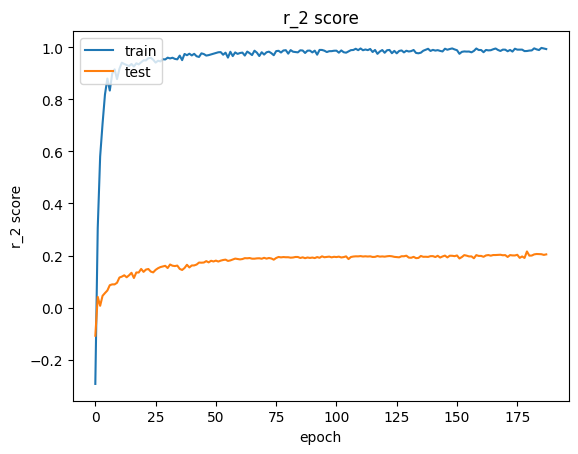

In [40]:
import matplotlib.pyplot as plt
plt.plot(history.history['r2_score'][2:])
plt.plot(history.history['val_r2_score'][2:])
plt.title('r_2 score')
plt.ylabel('r_2 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
adv_y

0       0.8
1       0.3
2       0.4
3       0.7
4       0.5
       ... 
1795    0.5
1796    0.9
1797    0.6
1798    0.2
1799    0.6
Name: y, Length: 1800, dtype: float64

# New adversary: classification instead of regression

In [42]:
adv_y_classification = np.array(adv_y*10-1, dtype=np.dtype("int"))
adv_y_test_classification = np.array(adv_y_test*10-1, dtype=np.dtype("int"))

In [43]:
# Baseline (classification)
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(adv_X, adv_y_classification)
gb.score(adv_X_test, adv_y_test_classification)

0.1761111111111111

In [44]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
adv_y_one_hot = enc.fit_transform(pd.array(adv_y_classification).reshape(-1, 1))
adv_y_test_one_hot = enc.transform(pd.array(adv_y_test_classification).reshape(-1, 1))

/home/jstock/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [55]:
# classification
adversary = keras.Sequential()
adversary.add(keras.Input(shape=(adv_X.shape[1],)))

#adversary.add(keras.layers.Reshape((adv_X.shape[1],1)))
#adversary.add(keras.layers.LSTM(4, activation='relu', return_sequences=False, return_state=False))

#adversary.add(keras.layers.AveragePooling1D(
#    #input_shape=(None,adv_X.shape[1],),
#    pool_size=3, strides=1, padding="valid", data_format="channels_last"
#))
#adversary.add(keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='valid'))
#adversary.add(keras.layers.Reshape((adv_X.shape[1],)))

#adversary.add(keras.layers.LayerNormalization(axis=1))
#adversary.add(keras.layers.Dense(500))
#adversary.add(keras.layers.Dense(16, activation='relu'))
#adversary.add(keras.layers.Dropout(rate=0.1))
#adversary.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
#adversary.add(keras.layers.Dense(2, activation='relu'))
#adversary.add(keras.layers.Flatten())

#adversary.add(keras.layers.Dense(32, activation="relu"))
adversary.add(keras.layers.Dense(40, activation='relu'))

#adversary.add(keras.layers.Dense(64, activation='relu'))

adversary.add(keras.layers.Dropout(rate=0.05))
#adversary.add(keras.layers.TimeDistributed(keras.layers.Dense(1)))
#adversary.add(keras.layers.Dense(2, activation='relu'))
#adversary.add(keras.layers.Flatten())
adversary.add(keras.layers.Dense(16, activation="relu"))
adversary.add(keras.layers.Dense(9, activation="softmax"))

#learning_rate=0.000005
initial_learning_rate=0.000003
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)
#learning_rate=lr_schedule
adversary.compile(optimizer="adam", loss=keras.losses.CategoricalCrossentropy(from_logits=False), metrics="accuracy")

In [56]:
history = adversary.fit(adv_X, adv_y_one_hot, batch_size=80, epochs=200, validation_data=(adv_X_test, adv_y_test_one_hot))

Epoch 1/200
23/23 [==============================] - 1s 36ms/step - loss: 3.2470 - accuracy: 0.1311 - val_loss: 2.2045 - val_accuracy: 0.1111
Epoch 2/200
23/23 [==============================] - 0s 8ms/step - loss: 2.1712 - accuracy: 0.1433 - val_loss: 2.1968 - val_accuracy: 0.0967
Epoch 3/200
23/23 [==============================] - 0s 8ms/step - loss: 2.1459 - accuracy: 0.1583 - val_loss: 2.1982 - val_accuracy: 0.1111
Epoch 4/200
23/23 [==============================] - 0s 13ms/step - loss: 2.1116 - accuracy: 0.1961 - val_loss: 2.1931 - val_accuracy: 0.1111
Epoch 5/200
23/23 [==============================] - 0s 7ms/step - loss: 2.0793 - accuracy: 0.2139 - val_loss: 2.2136 - val_accuracy: 0.1111
Epoch 6/200
23/23 [==============================] - 0s 7ms/step - loss: 2.0442 - accuracy: 0.2100 - val_loss: 2.1934 - val_accuracy: 0.1111
Epoch 7/200
23/23 [==============================] - 0s 7ms/step - loss: 2.0233 - accuracy: 0.1933 - val_loss: 2.1929 - val_accuracy: 0.1111
Epoch 8/200

# Test adversary

In [57]:
adversary.predict(adv_X_test)

57/57 [==============================] - 0s 2ms/step


array([[0.12446865, 0.12396079, 0.00446714, ..., 0.12463421, 0.12420047,
        0.12487885],
       [0.12446865, 0.12396079, 0.00446714, ..., 0.12463421, 0.12420047,
        0.12487885],
       [0.12446865, 0.12396079, 0.00446714, ..., 0.12463421, 0.12420047,
        0.12487885],
       ...,
       [0.12446865, 0.12396079, 0.00446714, ..., 0.12463421, 0.12420047,
        0.12487885],
       [0.12446865, 0.12396079, 0.00446714, ..., 0.12463421, 0.12420047,
        0.12487885],
       [0.12446865, 0.12396079, 0.00446714, ..., 0.12463421, 0.12420047,
        0.12487885]], dtype=float32)

In [54]:
adv_y_test

0      0.7
1      0.8
2      0.3
3      0.4
4      0.5
      ... 
355    0.6
356    0.7
357    0.2
358    0.6
359    0.1
Name: y, Length: 360, dtype: float64

In [56]:
adversary.evaluate(adv_X_test, adv_y_test)#, adv_y_test)

12/12 [==============================] - 0s 2ms/step - loss: 0.1012


0.10118263214826584

In [79]:
adv_y_test

0      0.9
1      0.8
2      0.4
3      0.2
4      0.1
      ... 
445    0.6
446    0.2
447    0.8
448    0.5
449    0.1
Name: y, Length: 450, dtype: float64

### Next steps
* Use adversary during training

In [130]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(adv_X, adv_y)
gb.score(adv_X_test, adv_y_test)

-0.027966356472107767

### (Data set analysis)

In [ ]:
import ydata_profiling

ydata_profiling.ProfileReport(X_test)

In [ ]:
# RANDOM DS
random_dict = {}
for attr in ds.X_train:
    print(f'{round(X_train_pr[attr].min(),2)} {round(X_train_pr[attr].max(),2)}')
    random_attr = np.random.rand(random_length)*(X_train_pr[attr].max()+abs(X_train_pr[attr].min()))-abs(X_train_pr[attr].min())
    random_dict[attr] = random_attr

In [ ]:
random_ds = pd.DataFrame(random_dict)